In [1]:
import numpy as np
from scipy.io import loadmat
import json
import os
import cv2
import matplotlib.pyplot as plt
import h5py
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras import mixed_precision

In [2]:
mpii_folder = "mpii"
dataset_folder = os.path.join(mpii_folder, "mpii_human_pose_v1")
image_folder = os.path.join(dataset_folder, "images")

In [8]:
# optional for gpus with lower vram
mixed_precision.set_global_policy('mixed_float16')

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3060 Ti, compute capability 8.6


In [14]:
print("GPUs available:", tf.config.list_physical_devices('GPU'))

GPUs available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Preparing the data
The images are .jpg files inside the images folder, while the joints/annotations for the images are located in a MATLAB file (.mat). We need to use the loadmat function to load the MATLAB file into the notebook. 



In [17]:
mat = loadmat(os.path.join(dataset_folder,'mpii_human_pose_v1_u12_1.mat'))
mat = mat['RELEASE']

In [18]:
data = []

for i, (anno, train) in enumerate(
    zip(mat['annolist'][0,0][0], 
        mat['img_train'][0,0][0])
):
    img_name = anno['image']['name'][0,0][0]
    train = int(train)
    
    for annorect in anno['annorect']:
        if annorect.size < 1 or 'scale' not in str(annorect.dtype):
            continue
            
        for i, annorect in enumerate(annorect):
            if annorect['scale'][0].size < 1:
                continue
                
            scale = float(annorect['scale'][0, 0])
            x, y = annorect['objpos'][0, 0]
            x = int(x[0,0])
            y = int(y[0,0])
            
            if 'annopoints' in str(anno['annorect'].dtype):
                annopoints = annorect['annopoints']
                if annopoints['point'][0][0].size == 16:
                    points = annopoints[0,0]
                    joint_coords = {}
                    visible_joints = {}
                    
                    for coord in points[0][0]:
                        joint_coords[int(coord['id'][0,0])] = [float(coord['x'][0,0]), float(coord['y'][0,0])]
                        visible_joints[int(coord['id'][0,0])] = coord['is_visible'].item() if (coord['is_visible'].size > 0) else 0
                    
                    data.append({
                        'filename': img_name,
                        'joint_coords': joint_coords,
                        'visible_joints': visible_joints,
                        'for_training': train,
                        'approx_loc': {
                            'scale': scale,
                            'x': x,
                            'y': y,
                        }
                    })
            else:
                data.append({
                        'filename': img_name,
                        'for_training': train,
                        'approx_loc': {
                            'scale': scale,
                            'x': x,
                            'y': y,
                        }
                    })

In [19]:
output_json = os.path.join(mpii_folder,'data.json')
file = open(output_json, 'w')
json.dump(data, file, indent=2)

## Checkout the data
Let's show a random image and overlay the joints

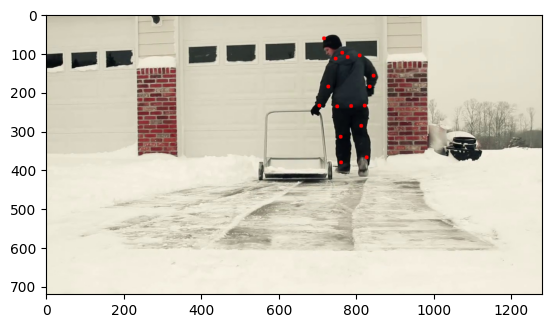

In [5]:
file = open(os.path.join(mpii_folder,'data.json'))
data = json.load(file)

def plot_joints(image_path, coordinates):
    image = cv2.imread(image_path)
    for joint in coordinates:
        cv2.circle(image, (int(joint[0]), int(joint[1])), 5, (0, 0, 255), -1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()

example = data[240]
img_filename = example.get('filename')
joints = example.get('joint_coords')

joint_coords = []
for joint, coords in joints.items():
    joint_coords.append((coords[0], coords[1]))

plot_joints(os.path.join(image_folder,img_filename), joint_coords)

## Preprocessing the data
We will have to resize and crop the images to the same size, we will also save this into a HDF5 file as it handles large amounts of data very well

In [6]:
file = open(os.path.join(mpii_folder,'data.json'))
data = json.load(file)

In [18]:
def preprocess_image(img_path, objpos, scale, img_size=(128,128)):
    img = cv2.imread(img_path)
    h, w, _ = img.shape
    
    crop_size = int(scale * 200) # Scale factor of 200px stated in dataset
    x1, y1 = int(objpos[0] - crop_size // 2), int(objpos[1] - crop_size // 2)
    x2, y2 = x1 + crop_size, y1 + crop_size
    
    x1, y1 = max(0, x1), max(0, y1)
    x2, y2 = min(w, x2), min(h, y2)
    
    # check if the crop is square or not
    # the idea is to pad the image with empty pixels (black) if the coordinates go beyond the image
    crop_width = x2 - x1
    crop_height = y2 - y1
    
    if crop_width != crop_height: # meaning the thought to be cropped image would not be square
        max_dim = max(crop_width, crop_height)
        
        padding_left = (max_dim - crop_width) // 2
        padding_top = (max_dim - crop_height) // 2
        
        padded_img = np.zeros((max_dim, max_dim, 3), dtype=np.uint8)
        padded_img[padding_top:padding_top+crop_height, padding_left:padding_left+crop_width] = img[y1:y2, x1:x2]
        
        cropped_img = padded_img
        x1 = x1 - padding_left
        y1 = y1 - padding_top
    else: # the new coordinates are perfectly square
        cropped_img = img[y1:y2, x1:x2]
    
    resized_img = cv2.resize(cropped_img, img_size)
    
    scale_factor = img_size[0] / max(crop_width, crop_height)
    transform_params = (x1, y1, scale_factor)
    
    return resized_img, transform_params

def adjust_keypoints(keypoints, transform_params):
    x1, y1, scale_factor = transform_params
    adjusted_keypoints = np.zeros((16,2), dtype=np.float32)
    
    for key, (x, y) in keypoints.items():
        x_new = (x - x1) * scale_factor
        y_new = (y - y1) * scale_factor
        adjusted_keypoints[int(key)] = [x_new, y_new]
    
    return adjusted_keypoints

def generate_heatmap(image_size, joints, sigma=2): # Inspiration from ChatGPT
    num_joints = len(joints)
    heatmaps = np.zeros((image_size[0], image_size[1], num_joints), dtype=np.float32)
    
    for i, (x,y) in enumerate(joints):
        x = int(x * image_size[1])
        y = int(y * image_size[0])
        
        if x < 0 or y < 0 or x >= image_size[1] or y >= image_size[0]:
            continue
        
        for j in range(image_size[0]):
            for k in range(image_size[1]):
                heatmaps[j, k, i] = np.exp(-((j - y) ** 2 + (k - x) ** 2) / (2 * sigma ** 2))
        
        heatmaps[:,:,i] /= np.max(heatmaps[:,:,i]) if np.max(heatmaps[:,:,i]) > 0 else 1
    
    return heatmaps

### Test the functions
Let's test out the functions by plotting the outputs over the original image 

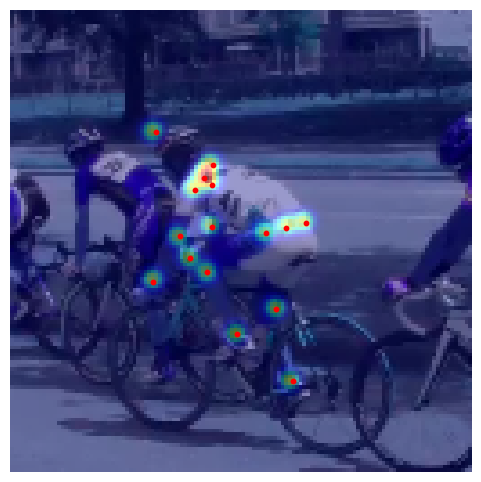

In [8]:
ann = data[423]

preprocessed_img, transform_params = preprocess_image(
    os.path.join(image_folder, ann['filename']), 
    (ann['approx_loc']['x'], ann['approx_loc']['y']), 
    ann['approx_loc']['scale'])

# Normalize the values
test_image = preprocessed_img
test_joints = adjust_keypoints(ann['joint_coords'], transform_params) / 128.0

# Generate a heatmap for every joint, and then combine them to a single heatmap for visualization purposes
heatmaps = generate_heatmap((128, 128), test_joints)
combined_heatmap = np.sum(heatmaps, axis=-1)

plt.figure(figsize=(6, 6))
plt.imshow(test_image)  
plt.imshow(combined_heatmap, cmap="jet", alpha=0.4)  

for i, (x, y) in enumerate(test_joints):
    x, y = x * 128, y * 128
    plt.scatter(x, y, c='red', s=10, marker='o')

plt.axis("off")
plt.show()

## Create and save a dataset
Seeing that the functions are working, we can now put this all in a dataset file.

We save it in a HDF5 file, because it's effective when storing complex data structures when it comes to large datasets. While we are on the topic of storage, we are here using float16 to store the heatmaps, but we could also use uint8, the problem 

In [63]:
def create_dataset(name, for_training):
    num_samples = sum(1 for ann in data if ann['for_training'] == for_training)
    
    with h5py.File(os.path.join(mpii_folder,name + '.h5'), 'w') as f:
        img_dataset = f.create_dataset("images", (num_samples, 128, 128, 3), dtype='uint8') # IMG SIZE (128,128,3)
        heatmaps_dataset = f.create_dataset("heatmaps", (num_samples, 128, 128, 16), dtype='uint8') # IMG SIZE + joints
        
        index = 0
        for ann in data:
            img_path = os.path.join(image_folder, ann['filename'])
            objpos = (ann['approx_loc']['x'], ann['approx_loc']['y'])
            scale = ann['approx_loc']['scale']
            
            preprocessed_img, transform_params = preprocess_image(img_path, objpos, scale)
            img_dataset[index] = preprocessed_img
            
            if ann['for_training'] == for_training:
                adjusted_keypoints = adjust_keypoints(ann['joint_coords'], transform_params) / 128 # normalize the values
                heatmaps_dataset[index] = (generate_heatmap((128, 128), adjusted_keypoints) * 255).astype(np.uint8) # scale to 0-255
            
            index += 1
            if index >= num_samples: break
    
    print(name + ".h5 successfully created")

create_dataset('train_dataset', for_training=1)

train_dataset.h5 successfully created


## Building a model

In [4]:
with h5py.File(os.path.join(mpii_folder, 'train_dataset.h5'), 'r') as f:
    images = np.array(f['images'], dtype=np.float16) / 255.0 # normalize the images to [0,1]
    heatmaps = np.array(f['heatmaps'], dtype=np.float16) / 255.0 # normalize the heatmaps to [0,1]
    num_samples = images.shape[0]

### Loading the dataset file
If you have enough memory you can directly load the dataset, try the code in the cell below, but if it fails, we will need to load the data from the file using a generator

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((images, heatmaps)).shuffle(num_samples, seed=42).batch(16).prefetch(tf.data.AUTOTUNE)

If the cell above throws an error, we will need to use the generator below:

In [10]:
def data_generator():
    for i in range(num_samples):
        yield images[i], heatmaps[i]

dataset = tf.data.Dataset.from_generator(
    data_generator,
    output_signature=(
        tf.TensorSpec(shape=(128, 128, 3), dtype=tf.float16),
        tf.TensorSpec(shape=(128, 128, 16), dtype=tf.float16),
    )
).shuffle(num_samples, seed=42).batch(8).prefetch(tf.data.AUTOTUNE)

### A model that predicts every joint/keypoint
This was our initial model, but after research we figured out that we need a model that predicts heatmaps of every single joint instead.

In [136]:
def build_keypoint_predictor(input_shape, num_keypoints=16):
    inputs = keras.Input(shape=input_shape)
    
    x = layers.Conv2D(64, (3,3), padding='same', activation="relu")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, (3,3), padding='same', activation="relu")(x)
    x = layers.BatchNormalization()(x)
    
    shortcut = x
    x = layers.Conv2D(128, (3,3), padding='same', activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, (3,3), padding='same', activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Add()([x, shortcut])
    
    shortcut = layers.Conv2D(256, (1,1), padding='same')(x)
    x = layers.Conv2D(256, (3,3), padding='same', activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(256, (3,3), padding='same', activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Add()([x, shortcut])
    
    x = layers.Conv2D(256, (3,3), strides=2, padding='same', activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2DTranspose(128, (3,3), strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.Conv2D(num_keypoints, (1,1), activation="sigmoid")(x)
    x = layers.Flatten()(x)
    x = layers.Dense(num_keypoints * 2)(x)
    outputs = layers.Reshape((num_keypoints, 2))(x)
    
    model = keras.Model(inputs, outputs, name="Simple_Keypoint_Detection")
    return model

### A more complicated model
The model below will predict a heatmap for every joint

In [11]:
def basic_block(input_tensor, filters, strides=1):
    shortcut = input_tensor
    x = layers.Conv2D(filters, (3,3), strides=strides, padding='same', use_bias=False)(input_tensor)
    x = layers.BatchNormalization(momentum=0.1)(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(filters, (3,3), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization(momentum=0.1)(x)
    if shortcut.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, (1,1), strides=strides,  use_bias=False)(shortcut)
        shortcut = layers.BatchNormalization(momentum=0.1)(shortcut)
    x = layers.Add()([x, shortcut])
    out = layers.ReLU()(x)
    return out

def make_layer(x, block, filters, blocks):
    for _ in range(blocks):
        x = block(x, filters)
    return x

def build_heatmap_model(input_shape, num_joints=16):
    inputs = keras.Input(shape=input_shape)
    
    x = layers.Conv2D(64, (3,3), strides=1, padding='same', use_bias=False)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    x = make_layer(x, basic_block, 64, 4)
    x = make_layer(x, basic_block, 128, 4)
    x = make_layer(x, basic_block, 256, 4)
    
    heatmaps = layers.Conv2D(num_joints, (1,1), padding='same', activation="sigmoid")(x)
    return keras.Model(inputs, heatmaps, name="Advanced_Heatmap_Detection")
    
input_shape = (128,128,3)
model = build_heatmap_model(input_shape)

model.compile(optimizer="adam", loss="mse", metrics=["mae"])

model.summary()

Model: "Advanced_Heatmap_Detection"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_28 (Conv2D)             (None, 128, 128, 64  1728        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_27 (BatchN  (None, 128, 128, 64  256        ['conv2d_28[0][0]']              
 ormalization)                  )                                        

In [12]:
model.fit(dataset, epochs=1)

2490/2490 [==============================] - 821s 325ms/step - loss: 0.0000e+00 - mae: 0.4719


In [13]:
# We should always save our model
model.save('model_v4.keras')

## Let's test the model
We will now use the model to predict heatmaps from a random test image, but before then we need to preprocess the test image as well

In [129]:
# Optional, load the model from storage
model = tf.keras.models.load_model('model_v4.keras')

In [50]:
data = json.load(open(os.path.join(mpii_folder,'data.json')))
joints = json.load(open(os.path.join(mpii_folder,'joints.json')))

In [14]:
def preprocess_test_image(test_image):
    image, transform_params = preprocess_image(
        os.path.join(image_folder, test_image['filename']), 
        (test_image['approx_loc']['x'], test_image['approx_loc']['y']), 
        test_image['approx_loc']['scale']
    )
    
    image = image / 255.0
    return image, transform_params

def visualize_predictions(img_path, keypoints):
    img = cv2.imread(img_path)
    for (x, y) in keypoints:
        if 0 <= x < img.shape[1] and 0 <= y < img.shape[0]:
            cv2.circle(img, (int(x), int(y)), 5, (0, 255, 0), -1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

def restore_keypoints(predictions, transform_params):
    x1, y1, scale_factor = transform_params
    keypoints = []

    for i in range(predictions.shape[1]):
        x_pred, y_pred = predictions[0, i]
        x_orig = (x_pred / scale_factor) + x1
        y_orig = (y_pred / scale_factor) + y1
        keypoints.append((x_orig, y_orig))

    return keypoints

In [69]:
testdata = []
for ann in data:
    if ann['for_training'] == 0:
        testdata.append(ann)

test_image = testdata[140]
test_image_location = os.path.join(image_folder, test_image['filename'])

input_image, transform_params = preprocess_test_image(test_image)
predictions = model.predict(np.expand_dims(input_image, axis=0))

1/1 [==============================] - 0s 32ms/step


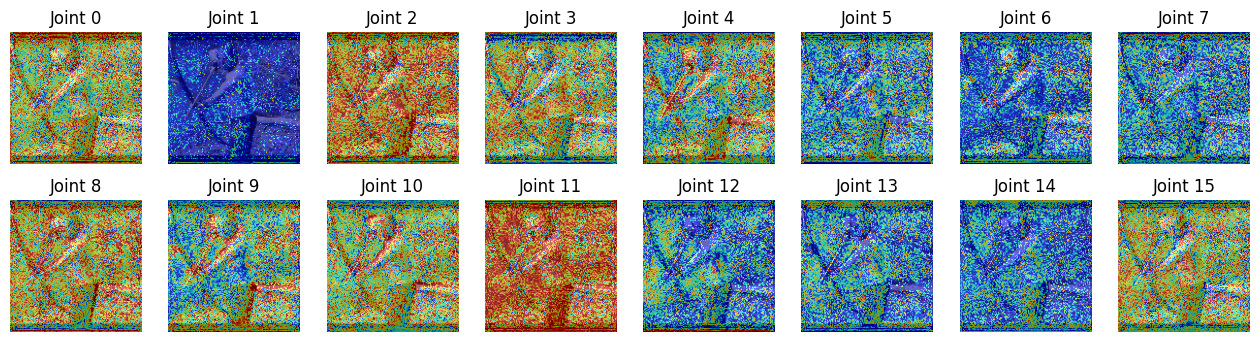

In [70]:
heatmaps = tf.squeeze(predictions)

fig, axes = plt.subplots(2, 8, figsize=(16, 4))
for i, ax in enumerate(axes.flat):
    ax.imshow(input_image)
    ax.imshow(heatmaps[:, :, i], cmap='jet', alpha=0.6)
    ax.set_title(f"Joint {i}")
    ax.axis('off')

plt.show()

## Extract joints
Above we have the predictions the model made based on each joint, lets now try to extract a joint from each heatmap

In [41]:
def extract_joints(heatmaps):
    coords = []
    for i in range(heatmaps.shape[-1]):
        heatmap = heatmaps[..., i]
        heatmap = tf.nn.softmax(tf.reshape(heatmap, [-1]))
        idx = tf.argmax(heatmap, axis=0)
        y, x = tf.unravel_index(idx, (heatmaps.shape[0], heatmaps.shape[1]))
        coords.append([x.numpy(), y.numpy()])
    return np.array(coords)

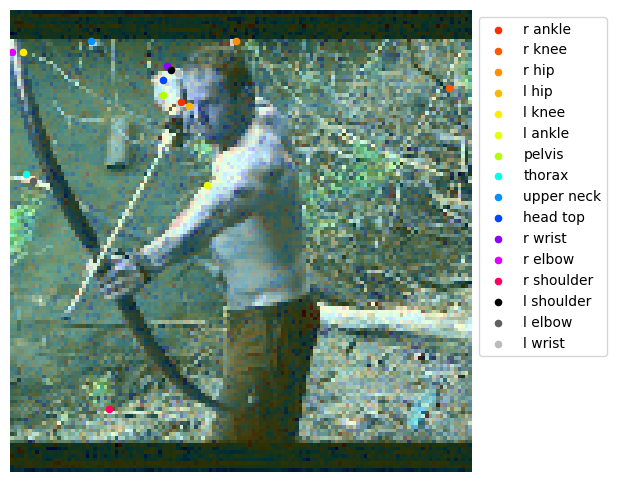

In [72]:
extracted_joints = extract_joints(heatmaps)

combined_heatmap = np.sum(heatmaps, axis=-1)
color_map = ['#ff2d00','#ff5900','#ff8f00','#ffb600','#ffec00','#e4ff00','#b2ff00','#00ffec','#0093ff','#0046ff','#8f00ff','#e000ff','#ff0064','#000','#606060','#bbbbbb']

plt.figure(figsize=(6, 6))
plt.imshow(input_image)  
plt.imshow(combined_heatmap, cmap="jet", alpha=0.2)  

for i, (x, y) in enumerate(extracted_joints):
    plt.scatter(x, y, c=color_map[i], s=20, marker='o', label=joints[str(i)])

plt.legend(bbox_to_anchor=(1,1))
plt.axis("off")
plt.show()